In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Some Helper Functions

In [2]:
'''a simple one_hot_encoder which encode the numbers from 0 to 9 in vector
for example: if y = 3  then one hot vector is [0,0,0,1,0,0,0,0,0,0]'''

def one_hot_encode(y, num_classes=10):
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot

In [3]:
'''ReLU (Rectified Linear Unit) its a simple to introduce non-linearity means it just convert y = x if x>0 and y = 0 if x < 0 '''

def relu(Z):
    return np.maximum(0,Z)   #if Z<0 then return 0 otherwise return Z 

In [25]:
def relu_derivative(Z):
    return (Z > 0).astype(float)


In [11]:


def softmax(Z):
    max_val = np.max(Z, axis=0, keepdims=True)
    Z_stable = Z - max_val
    exp_vals = np.exp(Z_stable)
    total = np.sum(exp_vals, axis=0, keepdims=True)
    return exp_vals / total


In [ ]:
"""here i am trying to explain the softmax fucntion and its use: 

Suppose for one sample (a single column in Z2) the output is:

Z2 = [2.3,0.5,-1.2,0.0,1.8,-0.7,-0.2,0.3,-1.0,0.9] ---->logits

The logit for class 0 is 2.3, for class 1 is 0.5, for class 2 is -1.2, and so on.

These numbers indicate how strongly the network "favors" each class before normalization

after softmax function .....

This is how the softmax function transforms the raw logits into a meaningful output probability vector 

A2 = [0.40766853, 0.06738715, 0.01231052, 0.04087238, 0.24726346,0.02029662, 0.03346347, 0.05517194, 0.01503611, 0.10052982]

A2[0]≈0.4076: The network estimates a 40.76% probability for class 0.

A2[4]≈0.2473: About 24.73% for class 4.

"""

'here i am trying to explain the softmax fucntion and its use'

In [12]:
Z2 = [2.3,0.5,-1.2,0.0,1.8,-0.7,-0.2,0.3,-1.0,0.9]
A2 = softmax(Z2)
A2

array([0.40766853, 0.06738715, 0.01231052, 0.04087238, 0.24726346,
       0.02029662, 0.03346347, 0.05517194, 0.01503611, 0.10052982])

In [23]:
def cross_entropy_loss(Y_pred, Y_true):
    m = Y_true.shape[1]
    eps = 1e-15  # to avoid log(0)
    loss = -np.sum(Y_true * np.log(Y_pred + eps)) / m
    return loss


## Neural Network Class: Neural_Network

### This class encapsulates the network architecture, forward pass, backward propagation, parameter updates, training, and prediction.

In [ ]:
"""
input_size = no of input neurons 784 (28*28)

output_size = no of class (10)  from 0 to 9

hidden_size = number of neurons in the hidden layer

learning_rate =  Step size for gradient descent updates


"""



In [26]:
class Neural_Network:
    '''np.random.randn(hidden_size, input_size)  because for each hidden neuron we need x weights and here x no of input so fo y neuron we need xy weights

    so here using np i create a 2d matrix of x row and y cols 

    the scalling factor is selected only becuase its perfect for relu and you can change it ..... 
    
    
    '''
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        #from input layer to hidden layer
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        
        #from hidden layer to ouput layer
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((output_size, 1))

    
    def forward(self,X):
        #simple forward pass  Z1 = W1*X +B1
        Z1 = np.dot(self.W1,X)+self.b1
        A1 = relu(Z1)


        #simple forward pass  Z2 = W1*A1 +B2
        Z2 = np.dot(self.W2,A1)+self.b2
        
        
        A2 = softmax(Z2)

        #cache: Save intermediate values needed for backpropagation.
        cache = (X, Z1, A1, Z2, A2)
        
        return A2, cache
    
    
    
    
    
    def backward(self, cache, Y):
        X, Z1, A1, Z2, A2 = cache
        m = X.shape[1]
        dZ2 = A2 - Y  # shape: (output_size, m)
        dW2 = (1./m) * np.dot(dZ2, A1.T)
        db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)
    
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = (1./m) * np.dot(dZ1, X.T)
        db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)
    
        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return grads

    
    def update_parameters(self, grads):
        self.W1 -= self.learning_rate * grads["dW1"]
        self.b1 -= self.learning_rate * grads["db1"]
        self.W2 -= self.learning_rate * grads["dW2"]
        self.b2 -= self.learning_rate * grads["db2"]

    
    
    def train(self, X, Y, epochs=10, batch_size=64, X_val=None, Y_val=None):
        m = X.shape[1]
        history = {"loss": [], "val_loss": []}
        for epoch in range(epochs):
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[:, i:i+batch_size]
                Y_batch = Y_shuffled[:, i:i+batch_size]
                A2, cache = self.forward(X_batch)
                loss = cross_entropy_loss(A2, Y_batch)
                grads = self.backward(cache, Y_batch)
                self.update_parameters(grads)
            A2_full, _ = self.forward(X)
            train_loss = cross_entropy_loss(A2_full, Y)
            history["loss"].append(train_loss)
            if X_val is not None and Y_val is not None:
                A2_val, _ = self.forward(X_val)
                val_loss = cross_entropy_loss(A2_val, Y_val)
                history["val_loss"].append(val_loss)
                print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}")
        return history
        
    
    
    
    
    
    
    def predict(self, X):
        A2, _ = self.forward(X)
        predictions = np.argmax(A2, axis=0)
        return predictions


        





In [14]:
train_csv_path = "..\\data\\mnist_train.csv"
test_csv_path = "..\\data\\mnist_test.csv"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)


In [15]:
X_train = train_df.drop("label", axis=1).values.astype(np.float32)
y_train = train_df["label"].values.astype(np.int32)
X_test = test_df.drop("label", axis=1).values.astype(np.float32)
y_test = test_df["label"].values.astype(np.int32)


In [16]:
X_train /= 255.0
X_test /= 255.0


In [17]:
y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)


In [18]:
X_train_T = X_train.T
X_test_T = X_test.T
Y_train_T = y_train_encoded.T
Y_test_T = y_test_encoded.T


In [21]:
input_size = 784      
hidden_size = 64      
output_size = 10      
learning_rate = 0.1
epochs = 10

In [27]:
nn = Neural_Network(input_size, hidden_size, output_size, learning_rate)

history = nn.train(X_train_T, Y_train_T, epochs=epochs, batch_size=64, X_val=X_test_T, Y_val=Y_test_T)

Epoch 1/10 - Loss: 0.2478 - Val Loss: 0.2445
Epoch 2/10 - Loss: 0.1823 - Val Loss: 0.1856
Epoch 3/10 - Loss: 0.1395 - Val Loss: 0.1462
Epoch 4/10 - Loss: 0.1218 - Val Loss: 0.1298
Epoch 5/10 - Loss: 0.1041 - Val Loss: 0.1144
Epoch 6/10 - Loss: 0.0905 - Val Loss: 0.1102
Epoch 7/10 - Loss: 0.0775 - Val Loss: 0.0983
Epoch 8/10 - Loss: 0.0733 - Val Loss: 0.0952
Epoch 9/10 - Loss: 0.0658 - Val Loss: 0.0902
Epoch 10/10 - Loss: 0.0631 - Val Loss: 0.0882


In [28]:
predictions = nn.predict(X_test_T)
accuracy = np.mean(predictions == np.argmax(Y_test_T, axis=0)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 97.16%


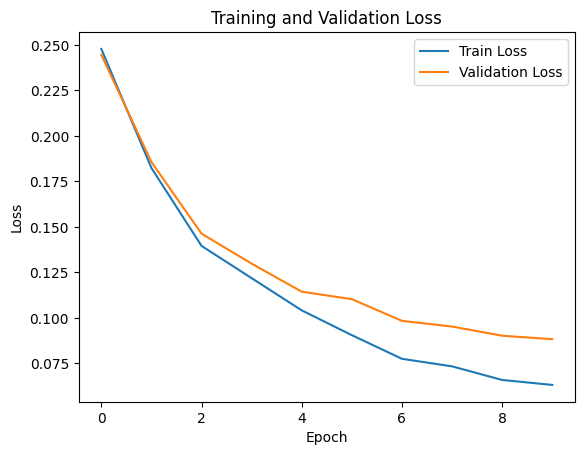

In [29]:
plt.plot(history["loss"], label="Train Loss")
if history["val_loss"]:
    plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
